# Bellabeat Fitness Data Analysis

## Initial Data Loading and Quality Assessment

### 📂 Data Source
- **Dataset**: `dailyActivity_merged.csv` from Fitabase (MTurk study)
- **Time Period**: March 12, 2016 - April 11, 2016
- **Original Files**: `mturkfitbit_export_3.12.16-4.11.16`

### 🔧 Data Processing Steps
1. **Data Loading**: 
   - Read daily activity data from CSV using pandas
   - Converted date strings to proper datetime objects

2. **Quality Checks**:
   - Removed records from invalid user (`ID 4388161847`)
   - Checked for duplicate entries (same user + date)
   - Verified date range coverage
   - Identified missing values

3. **Initial Statistics**:
   - Basic distribution metrics
   - Data type validation

### Key Metrics to Verify
```python
Unique Users: 33 
Covered Period: 2016-03-12 to 2016-04-11
Duplicate Records: 0
Missing Values: 0 (all columns)
```


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the path to the daily activity CSV file.
daily_activity_path = '../Data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv'

# Read the CSV file into a pandas DataFrame.
daily_activity = pd.read_csv(daily_activity_path)

# Convert the 'ActivityDate' column to datetime objects with the specified format.
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format='%m/%d/%Y')

print("\n🔍 METADATA:")
print(f"- Covered period: {daily_activity['ActivityDate'].min().date()} to {daily_activity['ActivityDate'].max().date()}")
print(f"- Unique users: {daily_activity['Id'].nunique()}")

# Exclude user with invalid data
daily_activity = daily_activity[daily_activity['Id'] != 4388161847]
# Count duplicate records based on 'Id' and 'ActivityDate'.
duplicate_records = daily_activity.duplicated(subset=['Id', 'ActivityDate']).sum()
print(f"- Duplicate records (ID+Date): {duplicate_records}")

print("\n🔍 MISSING VALUES:")
print(daily_activity.isnull().sum())

print("\n📊 BASIC STATISTICS:")
print(daily_activity.describe())

# Print a concise summary of the DataFrame, including data types and non-null values.
daily_activity.info()


🔍 METADATA:
- Covered period: 2016-03-12 to 2016-04-12
- Unique users: 35
- Duplicate records (ID+Date): 0

🔍 MISSING VALUES:
Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64

📊 BASIC STATISTICS:
                 Id                   ActivityDate    TotalSteps  \
count  4.490000e+02                            449    449.000000   
mean   4.632879e+09  2016-04-04 05:49:34.610244864   6663.204900   
min    1.503960e+09            2016-03-12 00:00:00      0.000000   
25%    2.347168e+09            2016-04-02 00:00:00   2106.000000   
50%    4.057193e+09            2016-04-05 00:00:0

# User Activity Profile Classification

## Activity Level Categorization System

### 📊 Classification Criteria (Steps per Day)
| Category            | Steps Range   | 
|---------------------|---------------|
| Very Active         | ≥ 10,000      | 
| Active               | 7,500 - 9,999 | 
| Lightly Active     | 5,000 - 7,499 | 
| Sedentary          | < 5,000       | 

### 🔍 Analysis Methodology
1. **Aggregation**:
   - Grouped data by user ID (`Id`)
   - Calculated mean values for:
     - Total steps
     - Calories burned
     - Activity minutes (Very/Fairly/Lightly Active)
     - Sedentary time

2. **Categorization**:
   - Applied step-based classification using `categorize_active()`
   - Rounded metrics to 2 decimal places for readability

3. **Output**:
   - Generated user profiles with:
     - Average activity metrics
     - Defined activity category

### Key Metrics Calculated
```python
Columns Created:
- mean_steps
- mean_calories  
- mean_veryActiveMinutes
- mean_fairlyActiveMinutes
- mean_lightlyActiveMinutes  
- mean_sedentaryMinutes
- active_category
```

### Expected Output Preview
The resulting DataFrame shows each user's:
- Average daily activity patterns
- Automatically assigned activity level
- Comprehensive movement profile

In [4]:
# Define a function to categorize activity levels based on the number of steps.
def categorize_active(steps):
    if steps >= 10000:
        return "Very Active"  
    elif steps >= 7500:
        return "Active"        
    elif steps >= 5000:
        return "Lightly Active"  
    else:
        return "Sedentary"    
# Group the daily activity data by user ID and calculate the mean for several activity metrics.
user_active_profile = (
    daily_activity
    .groupby('Id', as_index=False)
    .agg(
        mean_steps=('TotalSteps', 'mean'),
        mean_calories=('Calories', 'mean'),
        mean_veryActiveMinutes=('VeryActiveMinutes', 'mean'),
        mean_fairlyActiveMinutes=('FairlyActiveMinutes', 'mean'),
        mean_lightlyActiveMinutes=('LightlyActiveMinutes', 'mean'),
        mean_sedentaryMinutes=('SedentaryMinutes', 'mean')
    ).round(2)  # Round the calculated means to 2 decimal places.
    .assign(
        # Apply the categorize_active function to the 'mean_steps' column to create a new 'active_category' column.
        active_category=lambda x: x['mean_steps'].apply(categorize_active)
    )
)

# Display the first few rows of the resulting DataFrame.
user_active_profile.head()

,Id,mean_steps,mean_calories,mean_veryActiveMinutes,mean_fairlyActiveMinutes,mean_lightlyActiveMinutes,mean_sedentaryMinutes,active_category
0,1503960366,11640.53,1796.21,35.84,15.84,228.21,809.84,Very Active
1,1624580081,4226.26,1352.89,0.74,0.58,121.05,1278.32,Sedentary
2,1644430081,9274.80,2916.40,14.80,43.50,227.70,1034.20,Active
3,1844505072,3640.58,1615.92,0.75,0.75,158.50,1035.33,Sedentary
4,1927972279,2180.83,2254.00,0.00,1.67,111.67,952.92,Sedentary


# Activity Level Distribution Analysis


### Dominant Category: 
- The majority of users (38.2%) are classified as **Sedentary**. 
- This indicates that a significant portion of monitored users don't meet recommended physical activity levels.

### Active Categories:
- **Active** (26.5%) and **Very Active** (17.6%) users represent a smaller portion of the user base.

### Lightly Active Category:
- 17.6% of users are classified as **Lightly Active**.

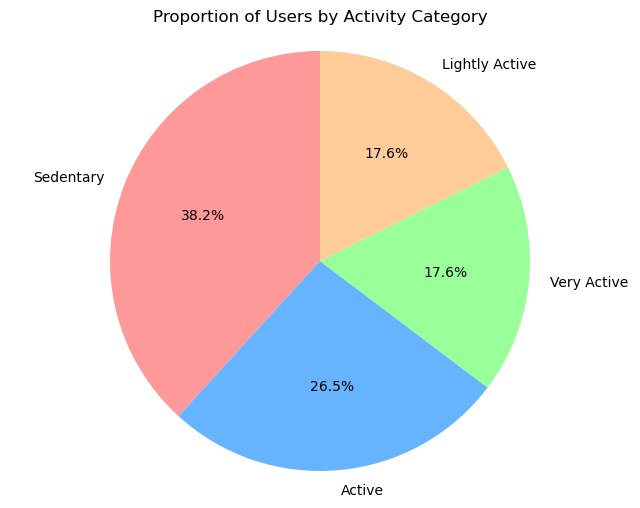

In [5]:
# Calculate the count of users in each activity category.
category_counts = user_active_profile['active_category'].value_counts()

# Create the pie chart.
plt.figure(figsize=(8, 6))  # Define the figure size.
plt.pie(category_counts,
        labels=category_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])  # Add colors to the pie chart.
plt.title('Proportion of Users by Activity Category')  # Add a title to the plot.
plt.axis('equal')  # Ensure the pie chart is circular.
plt.show()  # Display the plot.



# Sleep Analysis and Quality Assessment

## Sleep Data Processing Pipeline

### 📂 Data Source
- **Dataset**: `minuteSleep_merged.csv`
- **Time Period**: March 12, 2016 - April 11, 2016
- **Original Source**: Fitabase (MTurk study)

### 🔧 Data Cleaning Steps
1. **Initial Processing**:
   - Removed duplicate records (same user + timestamp)
   - Filtered valid sleep records (`value <= 1`)
   - Converted timestamps to datetime objects

2. **Daily Aggregation**:
   ```python
   sleep_daily = sleep_clean.groupby(['Id', 'date_only']).agg({
       'value': ['sum', 'count']
   })
   ```
   - Calculated:
     - Total sleep minutes
     - Number of sleep records
     - Converted to hours

### 🛌 Sleep Quality Classification
**Categorization Logic**:
| Category    | Hours Range | Description          |
|-------------|-------------|----------------------|
| excellent   | ≥ 8         | Recommended sleep    |
| good        | 7 - 8       | Adequate sleep       |
| bad         | < 7         | Insufficient sleep   |

### 🧪 Data Quality Control
1. **Consistency Metrics**:
   - Average daily sleep hours
   - Standard deviation (sleep pattern consistency)

2. **Quality Flags**:
   - `Insufficient data`: Users with incomplete data
   - `OK`: Valid data for analysis

### Output Structure
```python
Columns:
- Id: User identifier
- avg_daily_hours: Mean sleep duration
- consistency: Sleep pattern variability  
- sleep_category: Quality classification
- data_quality: Validity flag
```

In [7]:
# Load the sleep data from the CSV file.
sleep_minutes = pd.read_csv('../Data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv')

# Clean and preprocess the sleep data.
sleep_clean = (
    sleep_minutes
    .drop_duplicates(subset=['Id', 'date'])
    .query("value <= 1")  
    .assign(
        date=lambda x: pd.to_datetime(x['date']),
        date_only=lambda x: x['date'].dt.date  
    )
)

# Aggregate the sleep data to daily level
sleep_daily = (
    sleep_clean
    .groupby(['Id', 'date_only'], as_index=False)
    .agg(
        total_sleep_minutes=('value', 'sum'),
        sleep_records=('value', 'count')
    )
    .assign(
        total_sleep_hours=lambda x: x['total_sleep_minutes'] / 60
    )
)

# Define a function to categorize sleep quality based on daily sleep hours.
def categorize_sleep(daily_hours):
    if daily_hours >= 8:
        return 'excellent'
    elif daily_hours >= 7:
        return 'good'
    else:
        return 'bad'

# Calculate user sleep profiles.
user_sleep_profile = (
    sleep_daily
    .groupby('Id', as_index=False)
    .agg(
        avg_daily_hours=('total_sleep_hours', 'mean'),
        consistency=('total_sleep_hours', 'std')
    )
    .round(2)
)

user_sleep_profile['sleep_category'] = user_sleep_profile['avg_daily_hours'].apply(categorize_sleep)
# Evaluate data quality based on sleep consistency.
user_sleep_profile['data_quality'] = np.where(
    user_sleep_profile['consistency'].isna(),
    'Insufficient data',
    'OK'
)

# Filter out users with insufficient data.
user_sleep_profile = user_sleep_profile[user_sleep_profile['data_quality'] != 'Insufficient data']

user_sleep_profile.head()



,Id,avg_daily_hours,consistency,sleep_category,data_quality
0,1503960366,5.93,1.44,bad,OK
1,1644430081,5.97,3.54,bad,OK
2,1844505072,5.99,4.63,bad,OK
3,1927972279,5.91,3.17,bad,OK
5,2026352035,8.23,1.76,excellent,OK


# Sleep Quality Distribution Visualization

### Poor Sleep Dominates:
- The highest bar represents the **Poor** category
- Indicates most users (~14) have sleep quality classified as "Poor"

### Excellent Sleep is Rare:
- The shortest bar represents the **Excellent** category
- Shows very few users (only 1) report "Excellent" sleep quality

### Moderate Good Sleep:
- The **Good** category has a moderate number of users (~6)
- Falls between "Poor" and "Excellent" categories



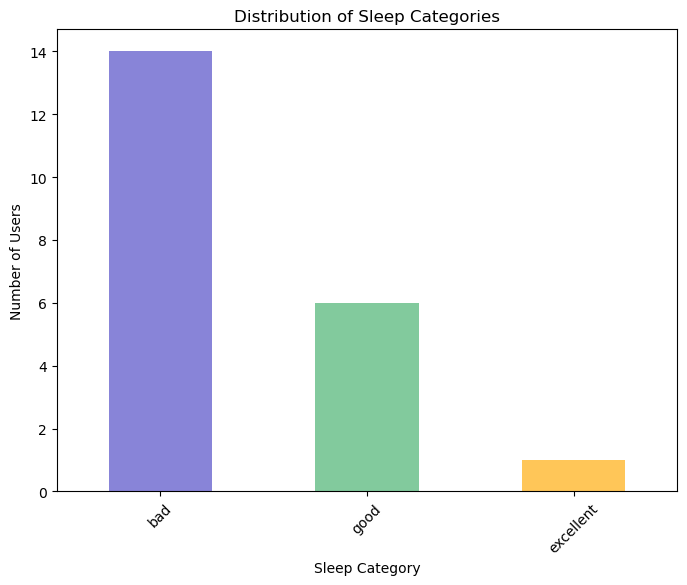

In [8]:
sleep_category_counts = user_sleep_profile['sleep_category'].value_counts()

# Creates the bar chart.
plt.figure(figsize=(8, 6))  # Sets the figure size.
sleep_category_counts.plot(kind='bar', color=['#8884d8', '#82ca9d', '#ffc658'])  # Plots the bar chart with specific colors.
plt.title('Distribution of Sleep Categories')  # Sets the chart title.
plt.xlabel('Sleep Category')  # Sets the x-axis label.
plt.ylabel('Number of Users')  # Sets the y-axis label.
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability.
plt.show()  # Displays the chart.

# Activity-Sleep Relationship Analysis

## Cross-Category Distribution Visualization

### 📊 Stacked Bar Chart: Activity Levels vs Sleep Quality

### Chart Description:
- **X-axis**: Activity categories (Active, Lightly Active, Sedentary, Very Active)
- **Y-axis**: Number of users
- **Color segments**: Represent sleep quality categories (Poor, Good, Excellent) within each activity group

### Key Observations:

#### Active Users:
- Significant count of users with both **Poor** and **Good** sleep quality
- No users reported **Excellent** sleep quality in this category

#### Sedentary Users:
- Majority report **Poor** sleep quality
- Smaller portions show **Good** and **Excellent** sleep quality

#### Lightly/Very Active Users:
- Fewer total users in these categories
- Varied distribution across sleep quality levels:
  - Lightly Active: Balanced between Poor and Good
  - Very Active: Notable presence in Good quality sleep


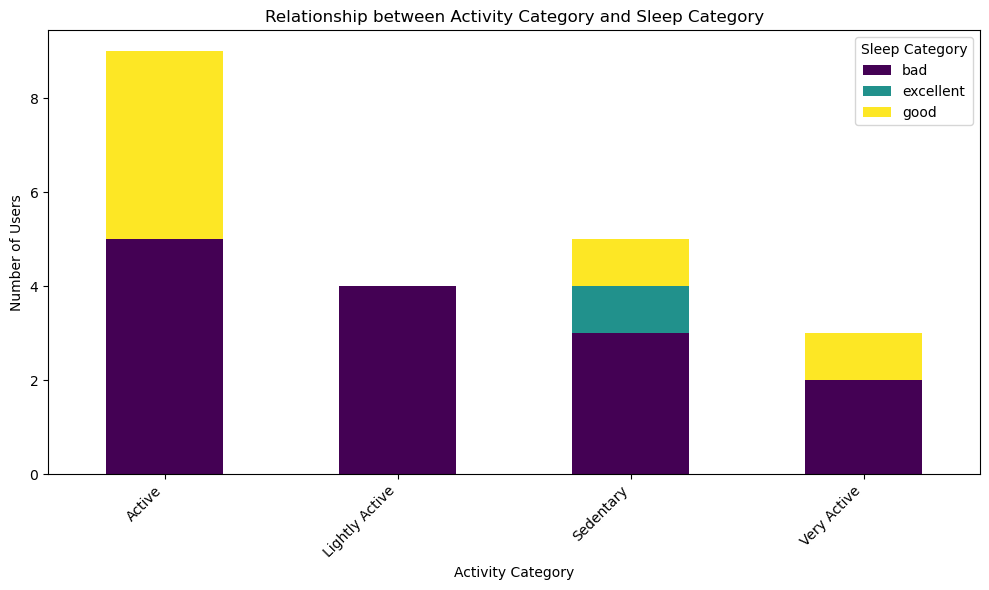

In [10]:
user_sleep_active_profile = pd.merge(
    user_active_profile,
    user_sleep_profile,
    on='Id',
    how='inner'  
)

cross_tab_activity_sleep = pd.crosstab(user_sleep_active_profile['active_category'], user_sleep_active_profile['sleep_category'])

# Create the stacked bar chart
cross_tab_activity_sleep.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Relationship between Activity Category and Sleep Category')  # Sets the chart title.
plt.xlabel('Activity Category')  # Sets the x-axis label.
plt.ylabel('Number of Users')  # Sets the y-axis label.
plt.xticks(rotation=45, ha='right')  # Rotates the x-axis labels for better readability.
plt.legend(title='Sleep Category')  # Sets the legend title.
plt.tight_layout()  # Adjusts the layout to fit everything properly.
plt.show()  # Displays the chart.


# Weekly Sleep Patterns Analysis

## Daily Sleep Duration Trends

### 📈 Line Chart: Average Sleep Hours by Day of Week

**Data Processing Pipeline**:
1. **Aggregation**:
   - Grouped by `Id` and `date_only`
   - Converted sleep minutes to hours (`value/60`)

2. **Day Categorization**:
   ```python
   days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                      'Friday', 'Saturday', 'Sunday']
   ```
   - Ensured proper weekday ordering
   - Maintained temporal sequence for accurate trend analysis

   ## Key Observations

### Weekday Sleep Patterns (Monday-Friday):
- Consistently **shorter sleep duration** (average <6.5 hours)
- Most pronounced dip on **Fridays** (lowest weekly average)
- Suggests potential:
  - Workweek stress impacts
  - Earlier wake-up times
  - Reduced sleep opportunity windows

### Weekend Sleep Patterns (Saturday-Sunday):
- Significant **sleep duration increase**
- **Peak on Saturdays** (average >7 hours)
- Sunday sleep remains:
  - Longer than weekdays
  - Slightly less than Saturday
- Indicates likely:
  - Catch-up sleep behavior
  - Reduced social/work obligations
  - Flexible morning schedules

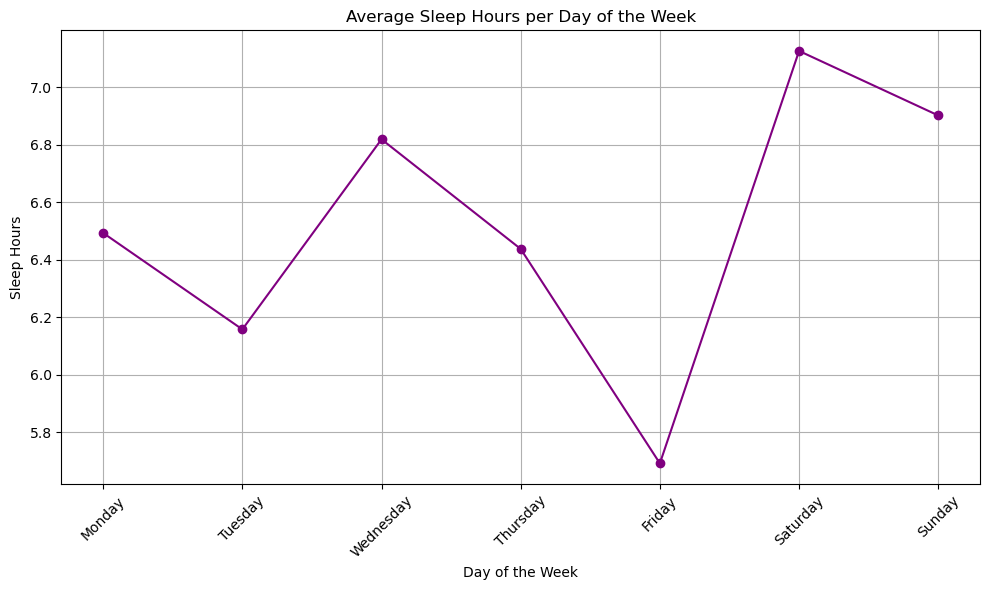

In [11]:
# Group by user and day, and sum the sleep minutes
df_sleep_aggregated = sleep_clean.groupby(['Id', 'date_only'])['value'].sum().reset_index()
df_sleep_aggregated['Sleep Hours'] = df_sleep_aggregated['value'] / 60

# --- Step 2: Add day of the week (using the same order as the first code) ---
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_sleep_aggregated['DayOfWeek'] = pd.to_datetime(df_sleep_aggregated['date_only']).dt.day_name()
df_sleep_aggregated['DayOfWeek'] = pd.Categorical(
    df_sleep_aggregated['DayOfWeek'], 
    categories=days_of_the_week, 
    ordered=True
)

# Calculate average and generate chart
average_sleep_per_day = df_sleep_aggregated.groupby('DayOfWeek', observed=True)['Sleep Hours'].mean()

# Chart (with style consistent with the first code)
plt.figure(figsize=(10, 6))
average_sleep_per_day.plot(
    marker='o', 
    color='purple', 
    linestyle='-',
    title='Average Sleep Hours per Day of the Week',
    xlabel='Day of the Week',
    ylabel='Sleep Hours',
    grid=True
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Sleep Data Availability Impact Analysis

## Comparative Analysis of Users With vs Without Sleep Records

### 🔍 Methodology
1. **Group Identification**:
   - Extracted unique user IDs with sleep data (`user_sleep_profile`)
   - Created boolean flag `has_sleep` in activity profiles

2. **Comparative Metrics**:
   ```python
   group_comparison = user_active_profile.groupby('has_sleep').agg({
       'mean_steps': 'mean',
       'mean_calories': 'mean',
       # ... other activity metrics
   })
   ```

3. **Visualization**:
   - Focused on key indicators: steps, calories, sendentary e active minutes
   - Clear group labeling: "With/Without Sleep Data"

### 📊 Key Comparison Metrics
| Metric                      | Without Sleep Data | With Sleep Data 
|-----------------------------|-----------------|--------------------
| Average Daily Steps         | 5816.64           | 7296.05              
| Average Calories Burned     | 2093.89           | 2258.88             
| Very Active Minutes         | 17.76            | 18.44	               
| Sedentary Minutes           | 1199.43           | 840.47              

### 🎯 Key Insights
1. **Activity Disparities**:
   - Users with sleep data show higher activity levels
   - Notable difference in steps

2. **Data Implications**:
   - Potential bias in full dataset analysis
   - Consider separate modeling approaches


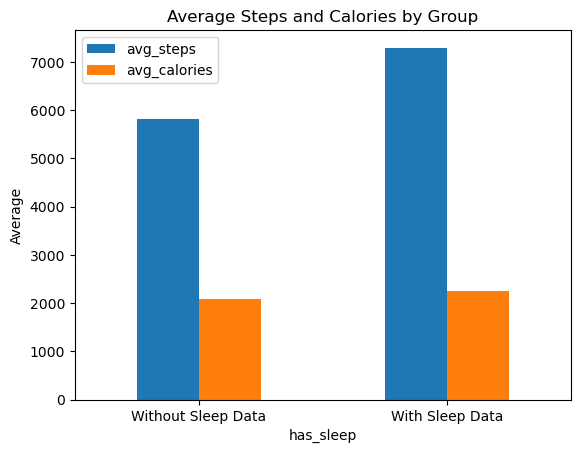

<Figure size 1000x500 with 0 Axes>

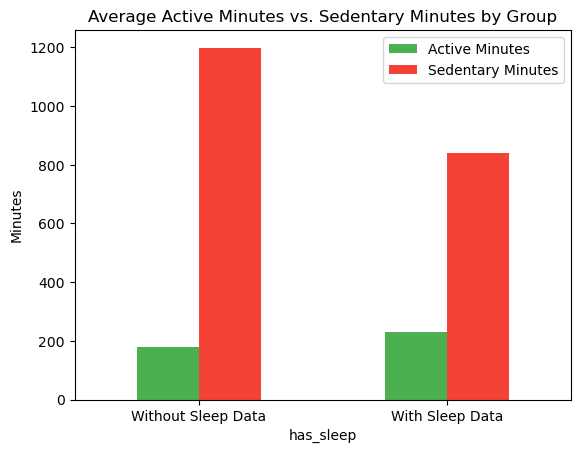

In [12]:
# List of IDs with sleep records ---
# This extracts the unique user IDs that have sleep data.
ids_with_sleep = user_sleep_profile['Id'].unique()

#  Add a column indicating if the user has sleep data ---
# A new column is created to indicate whether each user has sleep data (True or False).
user_active_profile['has_sleep'] = user_active_profile['Id'].isin(ids_with_sleep)

#  Group by the presence of sleep data and calculate the averages ---
# The dataset is grouped by the 'has_sleep' column, and averages are calculated for each group.
# This includes steps, calories, active minutes, and the total number of users in each group.
group_comparison = (
    user_active_profile
    .groupby('has_sleep', as_index=False)
    .agg(
        avg_steps=('mean_steps', 'mean'),
        avg_calories=('mean_calories', 'mean'),
        avg_very_active_minutes=('mean_veryActiveMinutes', 'mean'),
        avg_moderately_active_minutes=('mean_fairlyActiveMinutes', 'mean'),
        avg_lightly_active_minutes=('mean_lightlyActiveMinutes', 'mean'),
        avg_sedentary_minutes=('mean_sedentaryMinutes', 'mean'),
        total_users=('Id', 'count')
    )
    .round(2)  # Rounds the values to two decimal places for readability.
)

# Bar chart for comparison ---
# A bar plot is created to visualize the average steps and calories for both groups.
group_comparison.set_index('has_sleep')[['avg_steps', 'avg_calories']].plot(
    kind='bar', 
    title='Average Steps and Calories by Group',
    ylabel='Average'
)
plt.xticks([0, 1], ['Without Sleep Data', 'With Sleep Data'], rotation=0)
plt.show()

group_comparison['mean_totalActiveMinutes'] = (
    group_comparison['avg_very_active_minutes'] + 
    group_comparison['avg_moderately_active_minutes'] + 
    group_comparison['avg_lightly_active_minutes']
)


# Total Active Minutes vs. Sedentary Minutes ---
plt.figure(figsize=(10, 5))
group_comparison.set_index('has_sleep')[['mean_totalActiveMinutes', 'avg_sedentary_minutes']].plot(
    kind='bar',
    title='Average Active Minutes vs. Sedentary Minutes by Group',
    ylabel='Minutes',
    color=['#4CAF50', '#F44336']  # Green for active, red for sedentary
)
plt.xticks([0, 1], ['Without Sleep Data', 'With Sleep Data'], rotation=0)
plt.legend(['Active Minutes', 'Sedentary Minutes'])
plt.show()



# Weekly Activity Patterns Analysis

## Daily Trends in Steps, Calories, and Activity Minutes

### 📅 Data Preparation
1. **Day of Week Extraction**:
   ```python
   daily_activity['DayOfWeek'] = daily_activity['ActivityDate'].dt.day_name()
   ```

2. **Daily Averages Calculation**:
   ```python
   average_activity_per_day = daily_activity.groupby('DayOfWeek')[
       ['TotalSteps', 'VeryActiveMinutes', 'LightlyActiveMinutes', 'Calories']
   ].mean()
   ```

3. **Active Minutes Definition**:
   - Sum of `VeryActiveMinutes` and `LightlyActiveMinutes`

4. **Correct Day Ordering**:
   ```python
   days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                   'Friday', 'Saturday', 'Sunday']

### 📈 Interpretation Guide
1. **Activity Peaks**: Identify highest performance days
2. **Recovery Patterns**: Spot low-activity periods
3. **Consistency Check**: Compare daily variance across metrics

### 1. Tuesday Activity Slump
- **Consistently lowest activity levels** across metrics
- Potential explanations:
  - Post-weekend motivation dip
  - Work/school schedule patterns
  - Cultural factors (e.g., less incentive for midweek activity)

### 2. Weekend Activity Peaks (Saturday)
- **Highest step counts** and **active minutes**
- Particularly pronounced on Saturdays
- Contributing factors may include:
  - Leisure time availability
  - Social/sports activities
  - Intentional weekend workouts

### 3. Caloric Expenditure Patterns
- Shows **more stable distribution** than step/activity metrics
- Suggests:
  - Metabolic baseline effects
  - Non-exercise activity thermogenesis (NEAT)
  - Possible data reporting differences



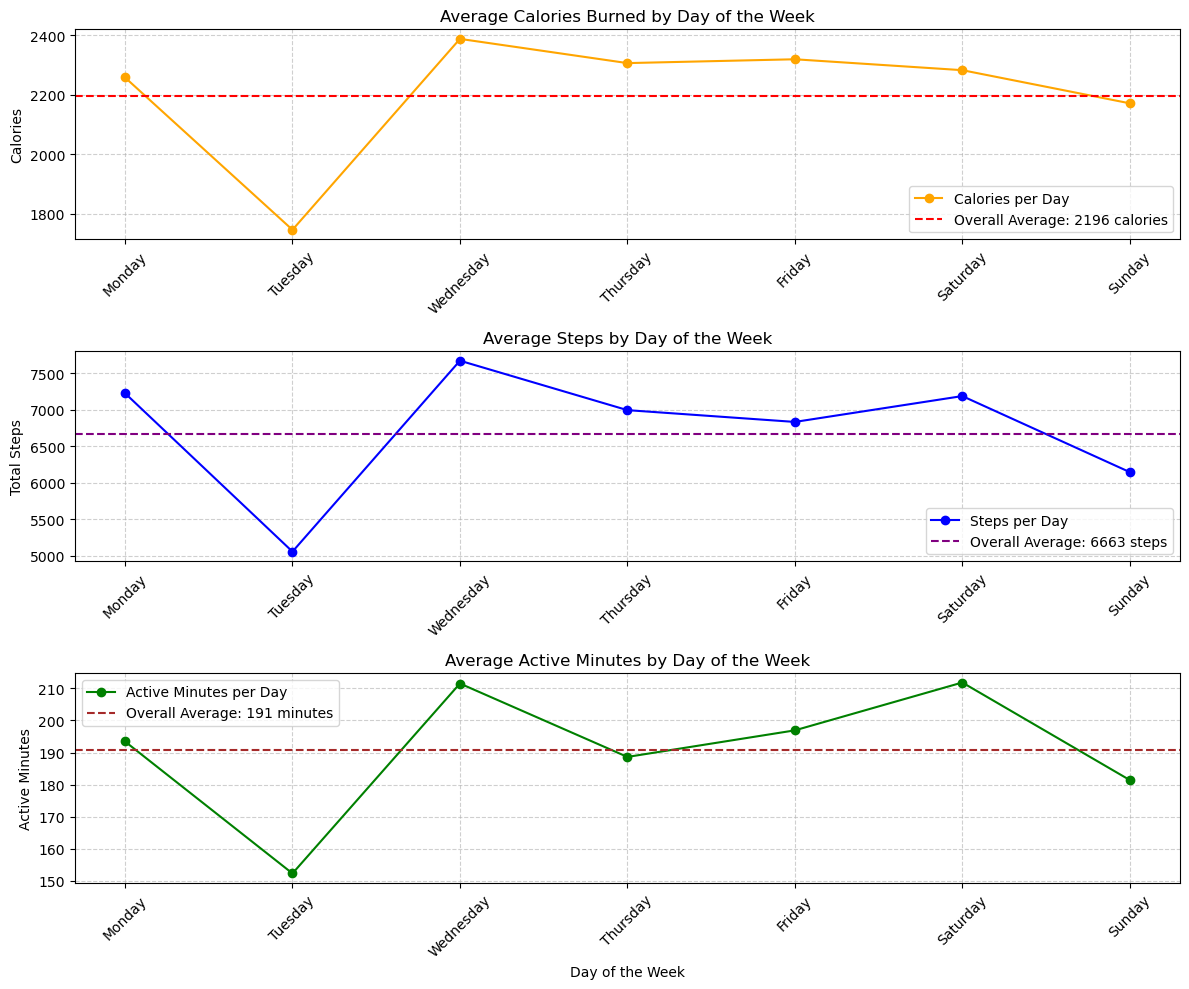

In [13]:
#Add the day of the week to the DataFrame 
# This creates a new column with the day of the week based on the 'ActivityDate'
daily_activity['DayOfWeek'] = daily_activity['ActivityDate'].dt.day_name()

#Step 2: Calculate daily averages and ActiveMinutes
# Group by the day of the week and calculate the average for each column
average_activity_per_day = daily_activity.groupby('DayOfWeek')[
    ['TotalSteps', 'VeryActiveMinutes', 'LightlyActiveMinutes', 'Calories']
].mean()

# Add a new column with the sum of Very Active and Lightly Active Minutes
average_activity_per_day['ActiveMinutes'] = (
    average_activity_per_day['VeryActiveMinutes'] + 
    average_activity_per_day['LightlyActiveMinutes']
)

#Reorder days of the week (and remove any missing days)
# Ensuring the days are displayed in order and not alphabetically
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_activity_per_day = average_activity_per_day.reindex(days_of_week).dropna()

# Calculate general averages for reference 
# These will be used as reference lines in the plots
avg_calories = daily_activity['Calories'].mean()
avg_steps = daily_activity['TotalSteps'].mean()
avg_active_minutes = average_activity_per_day['ActiveMinutes'].mean()

# Plot the graphs
plt.figure(figsize=(12, 10))

# Plot 1: Calories
plt.subplot(3, 1, 1)
plt.plot(average_activity_per_day.index, average_activity_per_day['Calories'], 
         marker='o', color='orange', label='Calories per Day')
plt.axhline(y=avg_calories, color='red', linestyle='--', label=f'Overall Average: {avg_calories:.0f} calories')
plt.title('Average Calories Burned by Day of the Week')
plt.ylabel('Calories')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

# Plot 2: Steps
plt.subplot(3, 1, 2)
plt.plot(average_activity_per_day.index, average_activity_per_day['TotalSteps'], 
         marker='o', color='blue', label='Steps per Day')
plt.axhline(y=avg_steps, color='purple', linestyle='--', label=f'Overall Average: {avg_steps:.0f} steps')
plt.title('Average Steps by Day of the Week')
plt.ylabel('Total Steps')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

# Plot 3: Active Minutes
plt.subplot(3, 1, 3)
plt.plot(average_activity_per_day.index, average_activity_per_day['ActiveMinutes'], 
         marker='o', color='green', label='Active Minutes per Day')
plt.axhline(y=avg_active_minutes, color='brown', linestyle='--', label=f'Overall Average: {avg_active_minutes:.0f} minutes')
plt.title('Average Active Minutes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Active Minutes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()  # Adjusts layout to avoid overlap
plt.show()

# Hourly Step Patterns Analysis

## Daily Activity Trends by Hour

### 🧹 Data Cleaning Steps
1. **Handled Missing Data**:
   ```python
   hourly_steps.dropna().drop_duplicates()
   ```
2. **Removed Invalid Values**:
   - Filtered out negative steps (`StepTotal >= 0`)

3. **Time Processing**:
   - Converted to datetime with exact format:
     ```python
     format='%m/%d/%Y %I:%M:%S %p'
     ```
   - Extracted hour component (0-23)

### 💡 Interpretation Guide
1. **Circadian Patterns**:
   - Natural activity peaks correlate with common daily routines
   - Noticeable dip during typical sleeping hours

2. **Health Implications**:
   - Compare personal patterns to population averages
   - Identify opportunities for increased activity

### Observed Activity Patterns by Time of Day
**🌙 Night (12 AM - 6 AM)**
   - Very low step counts (expected, as most users are asleep).

   - Implication: Confirms normal sleep/wake cycles in the dataset.

**🌅 Morning (7 AM - 12 PM)**
   - Gradual increase in steps, peaking sharply at 12 PM.

   - Key Drivers:

   - Commuting (work/school).

   - Morning routines (e.g., walking pets, errands).

   - 12 PM spike: Likely reflects lunchtime movement.

**🌇 Afternoon (1 PM - 7 PM)**
   - Sustained high activity, with a peak at 6 PM.

   - Potential Reasons:

   - Post-work exercise (gym, running).

   - Social activities or chores.

   - 6 PM spike: Aligns with end of typical workday.

**🌃 Evening (8 PM - 11 PM)** 
   - Steady decline as users wind down.

   - Behavioral Insight:

   - Reduced movement due to relaxation (TV, reading).

   - Prep for sleep.

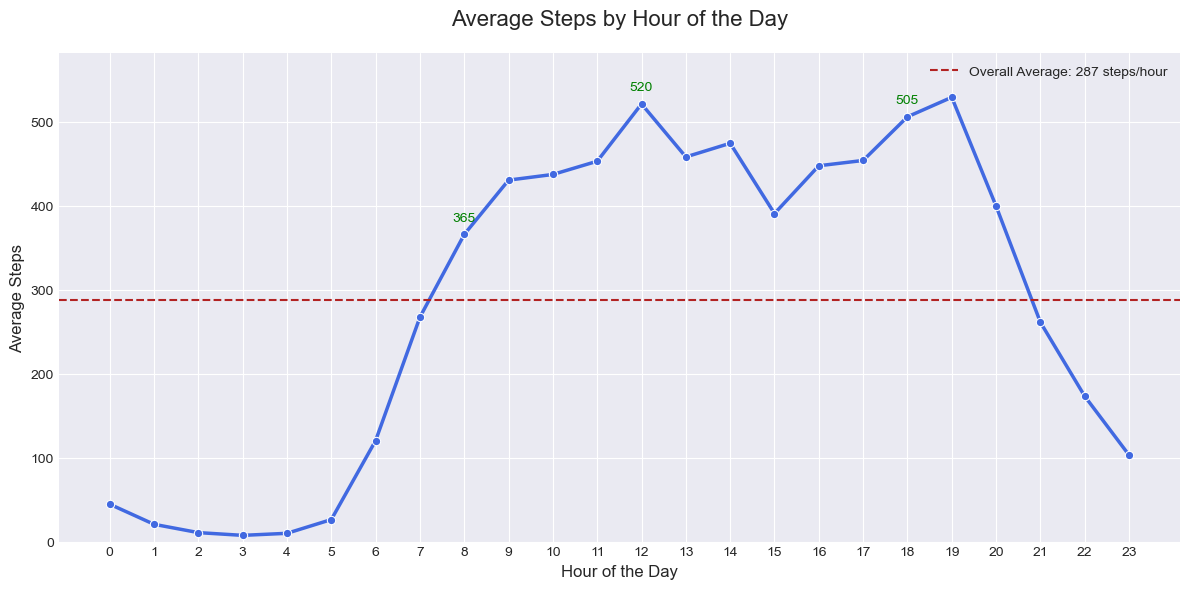

In [14]:
# Read the CSV file containing hourly step data
hourly_steps = pd.read_csv('../Data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlySteps_merged.csv')

# Remove missing values and duplicates
hourly_steps = (
    hourly_steps.dropna()
    .drop_duplicates()
)

# Filter out negative values in StepTotal (which doesn't make sense)
hourly_steps = hourly_steps[hourly_steps['StepTotal'] >= 0]


# Convert the 'ActivityHour' column to a datetime format
hourly_steps['ActivityHour'] = pd.to_datetime(hourly_steps['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')

# Extract the hour from the timestamp
hourly_steps['Hour'] = hourly_steps['ActivityHour'].dt.hour

# Group by hour and calculate the average number of steps
hourly_avg_steps = hourly_steps.groupby('Hour')['StepTotal'].mean().reset_index()

# Plot the graph
plt.style.use('seaborn-v0_8-darkgrid')  # Modern graph style
plt.figure(figsize=(12, 6))

# Create the line plot with markers and a thicker line
ax = sns.lineplot(
    data=hourly_avg_steps,
    x='Hour',
    y='StepTotal',
    marker='o',
    linewidth=2.5,
    color='royalblue'
)

# Customize the plot 
plt.title('Average Steps by Hour of the Day', fontsize=16, pad=20)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Steps', fontsize=12)
plt.xticks(range(0, 24))  # Display all hours on the X-axis
plt.ylim(0, hourly_avg_steps['StepTotal'].max() * 1.1)  # Add margin to the Y-axis

# Reference line 
plt.axhline(
    y=hourly_avg_steps['StepTotal'].mean(),
    color='firebrick',
    linestyle='--',
    label=f'Overall Average: {int(hourly_avg_steps["StepTotal"].mean())} steps/hour'
)

# Highlight specific peak hours: 8 AM, 12 PM, and 6 PM
peak_hours = [8, 12, 18]
for hour in peak_hours:
    value = hourly_avg_steps[hourly_avg_steps['Hour'] == hour]['StepTotal'].values[0]
    ax.annotate(
        f'{int(value)}',
        xy=(hour, value),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        color='green'
    )

plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()




# Hourly Caloric Expenditure Analysis

## Daily Energy Burn Patterns by Hour

### 🧼 Data Preparation
1. **Data Cleaning**:
   ```python
   hourly_calories.dropna().drop_duplicates()
   ```
2. **Invalid Value Removal**:
   - Excluded negative calories (`Calories >= 0`)

3. **Time Processing**:
   - Precise datetime conversion:
     ```python
     format='%m/%d/%Y %I:%M:%S %p'
     ```
   - Extracted 24-hour clock values (0-23)
### 💪 Metabolic Interpretation
1. **Activity Correlation**:
   - Peaks align with typical waking/active hours
   - Noticeable dip during sleep hours

2. **Health Context**:
   - Compare against recommended daily expenditure
   - Identify opportunities for increased activity

   ## Observed Patterns

**🌙 Nighttime (0:00 - 6:00)**
   - Low, stable calorie burn
   - Represents basal metabolic rate during sleep

**🌅 Morning (7:00 - 12:00)**
   - Gradual increase** in calorie expenditure  
   - Increased movement during lunch breaks
   - Post-meal thermic effect

**🌇 Afternoon (13:00 - 19:00)**
   - Sustained high calorie burn
   - Post-work exercise routines
   - Evening commute/errands
   - Household activities

**🌃 Evening (20:00 - 23:00)**
   - Progressive decline as activity decreases
   - Reflects winding down before sleep

## Key Insights

### Two Primary Calorie Burn Peaks:
1. **Noon (12:00)**  
   - Combination of physical movement + digestive metabolism

2. **Early Evening (18:00)**  
   - Highest activity period for most users
   - Prime time for intentional exercise

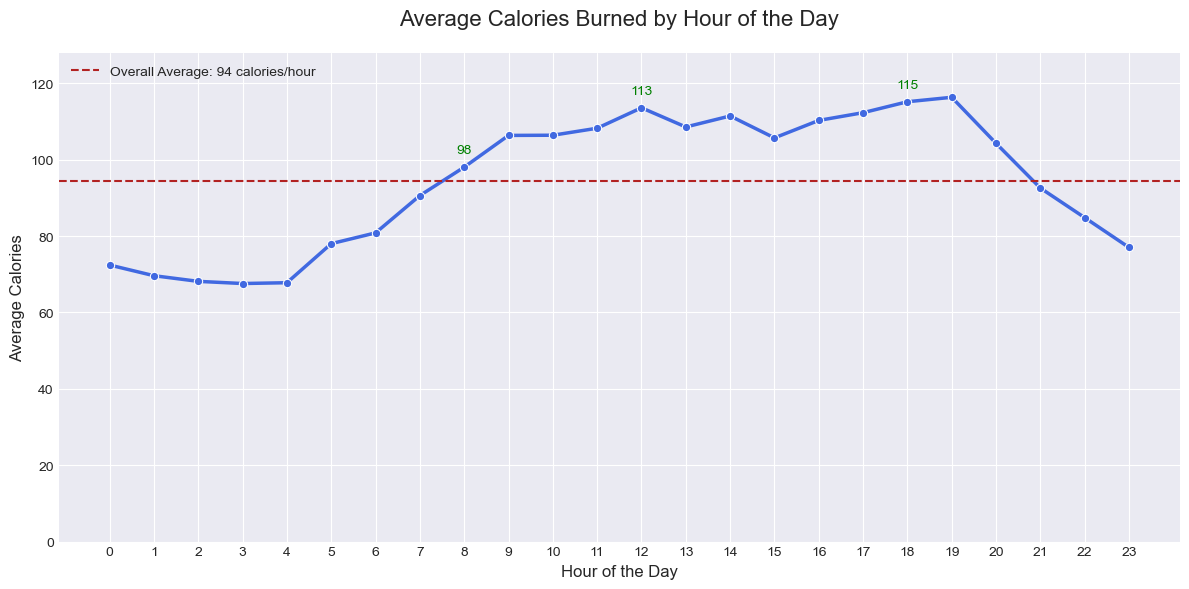

In [16]:
# Read the CSV file containing hourly calories data
hourly_calories = pd.read_csv('../Data/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyCalories_merged.csv')

# Remove missing values (NaN) and duplicates
hourly_calories = (
    hourly_calories.dropna()
    .drop_duplicates()
)

# Filter out negative values in 'Calories' (which is not possible)
hourly_calories = hourly_calories[hourly_calories['Calories'] >= 0]

# Convert the 'ActivityHour' column to a datetime format
hourly_calories['ActivityHour'] = pd.to_datetime(hourly_calories['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')

# Extract the hour from the timestamp
hourly_calories['Hour'] = hourly_calories['ActivityHour'].dt.hour

# Group by hour and calculate the average number of calories burned
hourly_avg_calories = hourly_calories.groupby('Hour')['Calories'].mean().reset_index()

# Plot the graph 
plt.style.use('seaborn-v0_8-darkgrid')  # Modern graph style
plt.figure(figsize=(12, 6))

# Create the line plot with markers and a thicker line
ax = sns.lineplot(
    data=hourly_avg_calories,
    x='Hour',
    y='Calories',
    marker='o',  # Markers at each data point
    linewidth=2.5,
    color='royalblue'
)

# Customize the plot 
plt.title('Average Calories Burned by Hour of the Day', fontsize=16, pad=20)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Calories', fontsize=12)
plt.xticks(range(0, 24))  # Display all hours on the X-axis
plt.ylim(0, hourly_avg_calories['Calories'].max() * 1.1)  # Add margin to the Y-axis

# Reference Line (optional) 
plt.axhline(
    y=hourly_avg_calories['Calories'].mean(),
    color='firebrick',
    linestyle='--',
    label=f'Overall Average: {int(hourly_avg_calories["Calories"].mean())} calories/hour'
)

# Highlight peak hours 
# Highlight specific peak hours: 8 AM, 12 PM, and 6 PM
peak_hours = [8, 12, 18]
for hour in peak_hours:
    value = hourly_avg_calories[hourly_avg_calories['Hour'] == hour]['Calories'].values[0]
    ax.annotate(
        f'{int(value)}',
        xy=(hour, value),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        color='green'
    )

plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



# Conclusion & Strategic Insights

## Key Findings

### 1. User Profile Analysis
- **Dominant sedentarism**: 38%+ users are sedentary (<5k steps/day)
- **Poor sleep patterns**:
  - Weekday average: <6.5h (below recommended)
  - Weekend recovery peak (Saturday: >7h)
- **Activity trends**:
  - Significant Tuesday activity drop
  - Afternoon movement peak (12PM-6PM)

### 2. Critical Correlations
- Users tracking **multiple metrics** (sleep, weight) tend to be **more active**
- Physical activity and sleep quality are **interconnected**

## Marketing Campaign Recommendations

### 🎯 1. Activity-Level Segmentation
  - *Goal*: Encourage category transitions (Sedentary → Lightly Active → Active)
  - *Tactics*:
    - App gamification ("Reach 7k steps for 3 days to level up")
    - Progressive rewards (badges, subscription discounts)
    - Educational content ("How small changes create big results")

### 🛌 2. Sleep as Engagement Driver
  - *Goal*: Link sleep tracking to physical activity
  - *Tactics*:
    - Personalized alerts: "Sleep trackers are 20% more active - try it!"
    - Product bundles ("Get Leaf + free sleep guide")
    - Weekly reports: "Your sleep vs. activity"

### ⏰ 3. Strategic Timing
- **Tuesday ("Reset Day")**:
  - Motivational content: "Beat the Tuesday slump with a 10-min walk"
- **Friday ("Rest Prep")**:
  - Reminders: "Sleep 30min earlier tonight"
- **Afternoon Peak ("Bellabeat Hour")**:
  - Push notifications: "It's your peak time! Take a walk now?"

### 📱 4. Metric Integration
- **"Holotracking" Incentives**:
  - "Track more, earn more":
    - Discounts for monitoring ≥3 metrics (sleep, steps, hydration)
    - YouTube content: "How sleep affects weight & energy"

## Next Steps for Validation
1. **Pilot testing** with control groups (sedentary vs active users)
2. **Collect Bellabeat-specific data** for comparison
3. **Influencer partnerships** showcasing improvement journeys

## Product Alignment
- **Leaf/Time**: Ideal for continuous sleep+activity tracking
- **Spring**: Afternoon hydration campaigns
- **Subscription**: Exclusive content ("Tuesday Boost Guide")